import models

In [29]:
import pandas as pd
from kan import *
from kan.utils import create_dataset_from_data
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

load data

In [30]:
df_masstrain = pd.read_csv('csv/pyradiomics_mass_train.csv')
df_masstest = pd.read_csv('csv/pyradiomics_mass_test.csv')
df_calctrain = pd.read_csv('csv/pyradiomics_calc_train.csv')
df_calctest = pd.read_csv('csv/pyradiomics_calc_test.csv')

In [31]:
print(df_masstrain.shape)
print(df_masstest.shape)
print(df_calctrain.shape)
print(df_calctest.shape)

(1450, 66)
(384, 66)
(1574, 66)
(311, 66)


print column names

In [32]:
## uncomment and run cell to print

print(df_masstrain.columns)
print(df_calctest.columns)


Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path',
       'original_shape2D_Elongation', 'original_shape2D_MajorAxisLength',
       'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface',
       'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter',
       'original_shape2D_PerimeterSurfaceRatio',
       'original_shape2D_PixelSurface', 'original_shape2D_Sphericity',
       'original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'o

data cleaning

In [33]:
## drop useless features

columns=[
    'patient_id',
    'left_or_right_breast',
    'abnormality_id',
    'abnormality_type',

    'image_file_path',
    'cropped_image_file_path',
    'ROI_mask_file_path',
    'image_path'
]

df_masstrain.drop(columns=columns, inplace=True)
df_masstest.drop(columns=columns, inplace=True)


In [34]:
# Columns to encode
cols_to_encode = ['image_view', 'mass_shape', 'mass_margins', 'pathology']
label_encoders = {}

# Create a copy to keep things clean
df_encoded_train = df_masstrain.copy()
df_encoded_test = df_masstest.copy()

for col in cols_to_encode:
    le = LabelEncoder()
    df_encoded_train[col] = le.fit_transform(df_encoded_train[col])
    df_encoded_test[col] = le.fit_transform(df_encoded_test[col])
    label_encoders[col] = le

df_encoded_train.head()

,breast_density,image_view,mass_shape,mass_margins,assessment,pathology,subtlety,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,...,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares
0,3,0,4,14,4,2,4,0.846472,616.314335,502.004980,...,0.928407,0.133450,2.474573,0.312687,2.234955,0.923074,0.468822,4.949146,2.101505,0.602391
1,3,1,4,14,4,2,4,0.897539,309.805534,262.937255,...,0.897990,0.052693,1.547551,0.451682,1.359706,0.940436,0.524013,3.095102,1.307013,0.276766
2,3,0,0,4,4,0,3,0.893191,573.773997,452.636720,...,0.880520,0.074755,2.733182,0.448109,1.539641,0.932531,0.605238,5.466364,1.464885,0.288590
3,3,1,0,4,4,0,3,0.926594,505.193212,427.242320,...,0.728752,0.027876,1.125884,0.753309,0.707630,0.873908,0.860178,2.251769,0.679754,0.109852
4,3,1,12,0,4,0,5,0.840487,542.354168,441.072556,...,0.939958,0.040505,2.847048,0.427190,1.576505,0.980083,0.586644,5.694097,1.536000,0.374897


inspect categorical feature encodings

In [35]:
for col in cols_to_encode:
    le = label_encoders[col]
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Encoding for {col}: {mapping}")

Encoding for image_view: {'CC': 0, 'MLO': 1}
Encoding for mass_shape: {'ARCHITECTURAL_DISTORTION': 0, 'ASYMMETRIC_BREAST_TISSUE': 1, 'FOCAL_ASYMMETRIC_DENSITY': 2, 'IRREGULAR': 3, 'IRREGULAR-ARCHITECTURAL_DISTORTION': 4, 'IRREGULAR-ASYMMETRIC_BREAST_TISSUE': 5, 'LOBULATED': 6, 'LOBULATED-IRREGULAR': 7, 'LOBULATED-LYMPH_NODE': 8, 'LYMPH_NODE': 9, 'OVAL': 10, 'OVAL-LOBULATED': 11, 'ROUND': 12}
Encoding for mass_margins: {'CIRCUMSCRIBED': 0, 'CIRCUMSCRIBED-ILL_DEFINED': 1, 'CIRCUMSCRIBED-MICROLOBULATED': 2, 'CIRCUMSCRIBED-MICROLOBULATED-ILL_DEFINED': 3, 'CIRCUMSCRIBED-OBSCURED': 4, 'CIRCUMSCRIBED-OBSCURED-ILL_DEFINED': 5, 'CIRCUMSCRIBED-SPICULATED': 6, 'ILL_DEFINED': 7, 'ILL_DEFINED-SPICULATED': 8, 'MICROLOBULATED': 9, 'MICROLOBULATED-ILL_DEFINED': 10, 'OBSCURED': 11, 'OBSCURED-CIRCUMSCRIBED': 12, 'OBSCURED-ILL_DEFINED': 13, 'OBSCURED-ILL_DEFINED-SPICULATED': 14, 'SPICULATED': 15}
Encoding for pathology: {'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 1, 'MALIGNANT': 2}


convert to tensor

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [37]:
X_train = df_encoded_train.drop(columns=["assessment", "pathology"]).values.astype(np.float64)
y_train = df_encoded_train["pathology"].values  # Target variable

X_test = df_encoded_test.drop(columns=["assessment", "pathology"]).values.astype(np.float64)
y_test = df_encoded_test["pathology"].values  # Target variable


X_train_tensor = torch.tensor(X_train, dtype=torch.float64).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float64).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float64).to(device)


print("Training set shape:", X_train_tensor.shape, y_train_tensor.shape)
print("Test set shape:", X_test_tensor.shape, y_test_tensor.shape)

Training set shape: torch.Size([1450, 56]) torch.Size([1450])
Test set shape: torch.Size([384, 56]) torch.Size([384])


In [38]:
input_dim = X_train_tensor.shape[1]
input_dim

56

hyperparameters

In [39]:
torch.set_default_dtype(torch.float64)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[input_dim,1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [40]:
dataset = create_dataset_from_data(X_train_tensor, y_train_tensor, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1160, 56]), torch.Size([1160]))

train

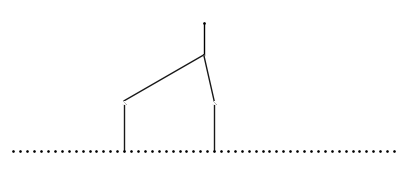

In [41]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

In [42]:
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001);

| train_loss: 1.43e+00 | test_loss: 1.38e+00 | reg: 1.05e+01 | : 100%|█| 100/100 [00:19<00:00,  5.13


saving model version 0.1


In [43]:
# model = model.prune()
# model.plot()

predict

In [ ]:
# Predict ## this method of prediction is not very legit, try using CCE loss for loss fn instead of default MSE loss
y_pred_cont = model(X_test_tensor).squeeze()  # shape: [384]
y_pred = torch.round(y_pred_cont).long().clamp(0, 2)  # round to nearest class (0, 1, 2)
y_pred

tensor([0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        2, 0, 1, 0, 1, 1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        2, 2, 0, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2, 0, 0,
        0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        2, 2, 1, 2, 0, 2, 0, 1, 2, 1, 2,

In [45]:
y_test_tensor.shape

torch.Size([384])

In [46]:

accuracy = accuracy_score(y_test, y_pred.cpu().numpy())
accuracy

0.2786458333333333

In [47]:
# Fit
# model.fit(train_dataset, opt="LBFGS", steps=100, lamb=0.001)

# Predict
# y_pred = model(X_test_tensor)
# y_pred_classes = y_pred.argmax(dim=1)

# # Accuracy
# accuracy = (y_pred_classes == y_test_tensor).float().mean().item()
# print("Accuracy:", accuracy)